In [450]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt
from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [653]:
# Many examples adapted from the official pymc3 documentation and Mark Dregan's tutorial on Bayesian techniques:
# https://github.com/markdregan/Bayesian-Modelling-in-Python

In [225]:
nypd = pd.read_csv("nypd_df.csv", parse_dates=True)

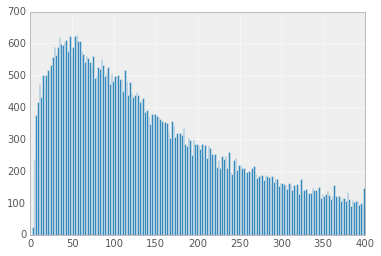

In [260]:
# The shape of the data is still recognizable with 10% of the data (smaller sample helps computational exploration)
nypd['responsetime'].sample(frac=.1).hist(bins=200, range=[0, 400])

In [298]:
df = nypd.sample(frac=.08)

In [299]:
y_obs = df['responsetime'].values

In [422]:
#Create out of sample (oos) dataframe to predict
oos = nypd[~nypd.index.isin(df.index)].sample(n=1000)

In [300]:
y_obs.shape

(58324,)

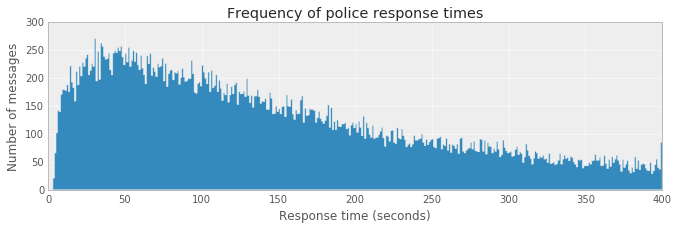

In [301]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of police response times')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(y_obs, 
             range=[0, 400], bins=400, histtype='stepfilled')

A frequentist measure of the value of $mu$ for a poisson distribution

In [302]:
def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 233.275481073
CPU times: user 55 µs, sys: 1e+03 ns, total: 56 µs
Wall time: 61 µs


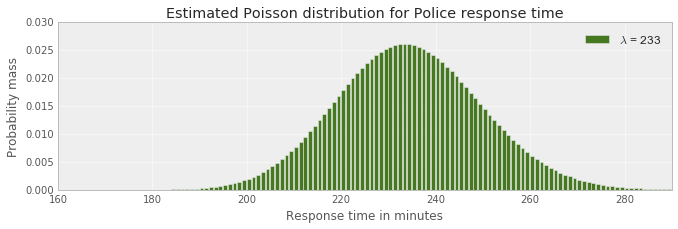

In [303]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 290
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(160, x_lim)
_ = ax.set_ylim(0, 0.03)
_ = ax.set_xlabel('Response time in minutes')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Police response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

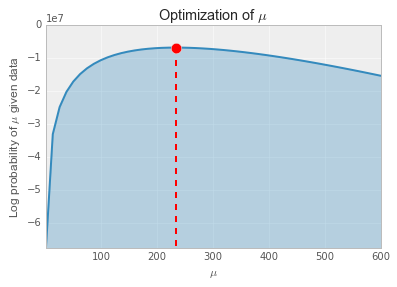

In [304]:
x = np.linspace(1, 600)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=600)

In [187]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=400)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=y_obs)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

INFO (theano.gof.compilelock): Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


Applied interval-transform to mu and added transformed mu_interval to model.
 [-------          20%                  ] 40984 of 200000 complete in 26.5 sec

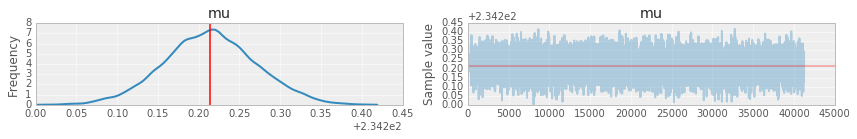

In [188]:
_ = pm.traceplot(trace, vars=['mu'], lines={'mu': freq_results['x']})

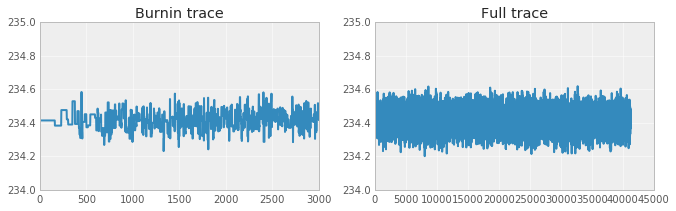

In [195]:
fig = plt.figure(figsize=(11,3))
plt.subplot(121)
_ = plt.title('Burnin trace')
_ = plt.ylim(ymin=234, ymax=235)
_ = plt.plot(trace.get_values('mu')[:3000])
fig = plt.subplot(122)
_ = plt.title('Full trace')
_ = plt.ylim(ymin=234, ymax=235)
_ = plt.plot(trace.get_values('mu'))

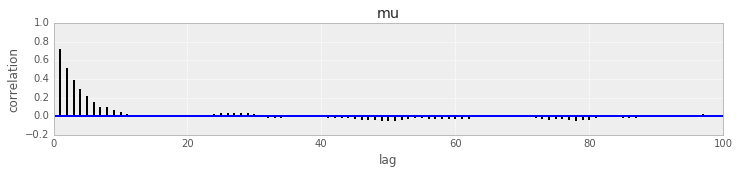

In [196]:
_ = pm.autocorrplot(trace[:5000], varnames=['mu'])

In [305]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=400)
    y_est = pm.Poisson('y_est', mu=mu, observed=y_obs)

    y_pred = pm.Poisson('y_pred', mu=mu)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

INFO (theano.gof.compilelock): Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 120.5 sec

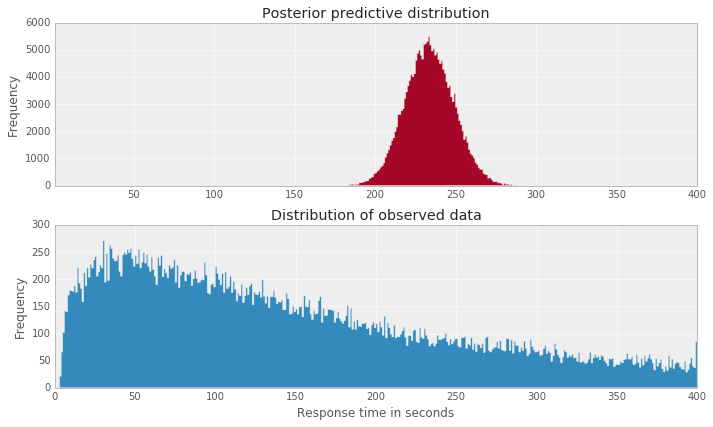

In [306]:
x_lim = 400
burnin = 2000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(y_obs, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

In [492]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=1)
    mu = pm.Uniform('mu', lower=0, upper=400)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=y_obs)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(2000, step, start=start, progressbar=True)

Applied log-transform to alpha and added transformed alpha_log to model.
Applied interval-transform to mu and added transformed mu_interval to model.

INFO (theano.gof.compilelock): Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock



 [-----------------100%-----------------] 2000 of 2000 complete in 21.3 sec

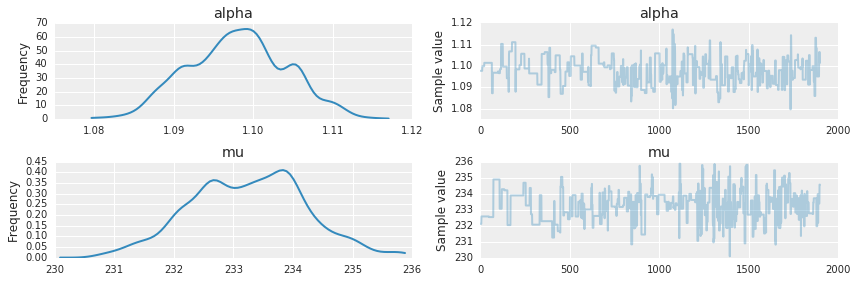

In [494]:
_ = pm.traceplot(trace[100:], vars=['alpha', 'mu'])

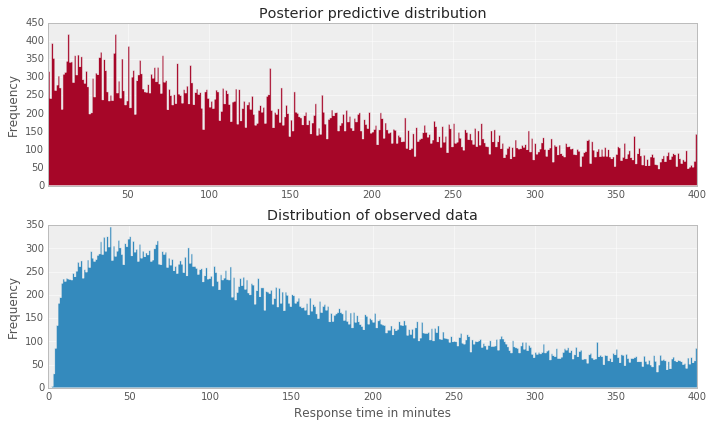

In [204]:
x_lim = 400
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(y_obs, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in minutes')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

In [495]:
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

In [ ]:
df = df.rename(columns={"Distance Km": "distance"})

In [633]:
df_shared = shared(df[["distance", "isweekend", "samezip", "responsetime"]].values)

In [634]:
df[["distance", "isweekend", "samezip", "responsetime"]].values

array([[   0.74080743,    0.        ,    1.        ,  153.        ],
       [   1.4929407 ,    0.        ,    0.        ,  205.        ],
       [   0.74671005,    0.        ,    0.        ,  423.        ],
       ..., 
       [   0.45256431,    1.        ,    1.        ,  109.        ],
       [   1.98451628,    0.        ,    0.        ,  170.        ],
       [   0.51866449,    0.        ,    1.        ,  273.        ]])

In [635]:
shared_dist = shared(df["distance"].values)
shared_weekend = shared(df["isweekend"].values)
shared_zip = shared(df["samezip"].values)
shared_time = shared(df["responsetime"].values)

In [499]:
# Convert categorical variables to integer
le_precincts = preprocessing.LabelEncoder()
precincts_idx = le_precincts.fit_transform(df['PolicePrct'])
precincts = le_precincts.classes_
precincts_shared_idx = shared(precincts_idx)
n_precincts = len(precincts)

# Convert categorical variables to integer
le_borough = preprocessing.LabelEncoder()
boroughs_idx = le_borough.fit_transform(df['Borough'])
boroughs = le_borough.classes_
boroughs_shared_idx = shared(boroughs_idx)
n_boroughs = len(boroughs)

with pm.Model() as model:

    borough = pm.Normal('borough', mu=0, sd=100, shape=n_boroughs)
    precinct = pm.Normal('precinct', mu=0, sd=100, shape=n_precincts)
    slope_distance = pm.Normal('slope_distance', mu=0, sd=100)
    slope_is_weekend = pm.Normal('slope_is_weekend', mu=0, sd=100)
    slope_same_zip = pm.Normal('slope_same_zip', mu=0, sd=100)
            
    mu = tt.exp(borough[boroughs_shared_idx]
                + precinct[precincts_shared_idx]
                + slope_is_weekend*shared_weekend
                + slope_same_zip*shared_zip
                + slope_distance*shared_dist)
    
    alpha = pm.Exponential('alpha', lam=1.1)
    
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=y_obs)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

INFO (theano.gof.compilelock): Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/joshua/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


Applied log-transform to alpha and added transformed alpha_log to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 23792.3 sec

In [636]:
# Convert categorical variables to integer
le_precincts = preprocessing.LabelEncoder()
precincts_idx = le_precincts.fit_transform(df['PolicePrct'])
precincts = le_precincts.classes_
precincts_shared_idx = shared(precincts_idx)
n_precincts = len(precincts)

# Convert categorical variables to integer
le_borough = preprocessing.LabelEncoder()
boroughs_idx = le_borough.fit_transform(df['Borough'])
boroughs = le_borough.classes_
boroughs_shared_idx = shared(boroughs_idx)
n_boroughs = len(boroughs)

with pm.Model() as w_model:

    borough = pm.Normal('borough', mu=0, sd=100, shape=n_boroughs)
    precinct = pm.Normal('precinct', mu=0, sd=100, shape=n_precincts)
    slope_distance = pm.Normal('slope_distance', mu=0, sd=100)
    slope_is_weekend = pm.Normal('slope_is_weekend', mu=0, sd=100)
    slope_same_zip = pm.Normal('slope_same_zip', mu=0, sd=100)
            
    beta = tt.exp(borough[boroughs_shared_idx]
                + precinct[precincts_shared_idx]
                + slope_is_weekend*shared_weekend
                + slope_same_zip*shared_zip
                + slope_distance*shared_dist)
    
    alpha = pm.Exponential('alpha', lam=1.1)
    
    y_est = pm.Weibull('y_est', beta=beta, alpha=alpha, observed=y_obs)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    w_trace = pm.sample(200000, step, start=start, progressbar=True)

Applied log-transform to alpha and added transformed alpha_log to model.
 [-----------------63%----              ] 127661 of 200000 complete in 15037.0 sec

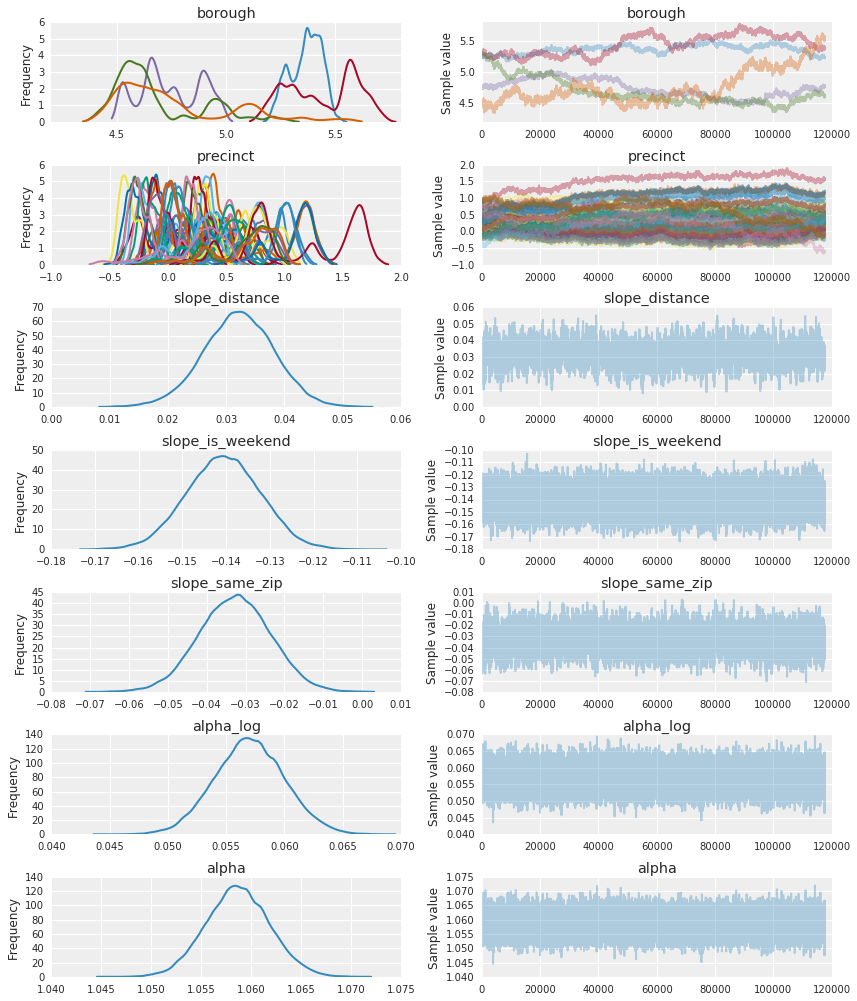

In [637]:
_ = pm.traceplot(w_trace[10000:])

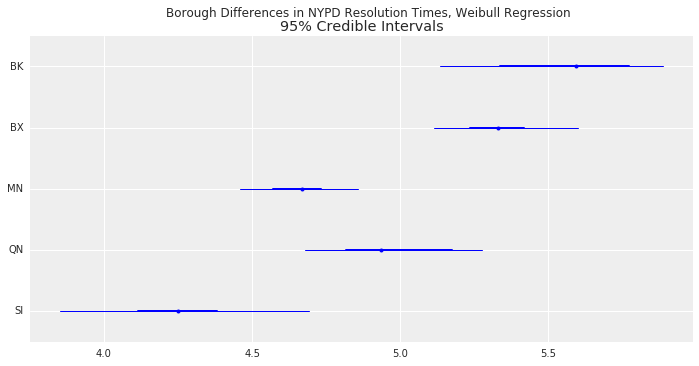

In [638]:
_ = plt.figure(figsize=(10, 5))
_ = pm.forestplot(trace[10000:], vars=['borough'], ylabels=boroughs)
plt.suptitle("Borough Differences in NYPD Resolution Times, Weibull Regression", size=12)

In [526]:
oos = nypd[(~nypd.index.isin(df.index)) & (nypd.responsetime < 400)].sample(n=5000)

In [639]:
shared_dist.set_value(oos["Distance Km"].values)
shared_weekend.set_value(oos["isweekend"].values)
shared_zip.set_value(oos["samezip"].values)
shared_time.set_value(oos["responsetime"].values)

In [640]:
# Change values of the shared variables to predict out of sample distribution
precincts_idx = le_precincts.transform(oos['PolicePrct'])
precincts = le_precincts.classes_
precincts_shared_idx.set_value(precincts_idx)
n_precincts = len(precincts)

boroughs_idx = le_borough.transform(oos['Borough'])
boroughs = le_borough.classes_
boroughs_shared_idx.set_value(boroughs_idx)
n_boroughs = len(boroughs)

In [646]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(w_trace, model=w_model, samples=200)

In [647]:
np.power((oos['responsetime'].values - ppc['y_est'].mean(axis=0)), 2).mean()

23434.801748119764

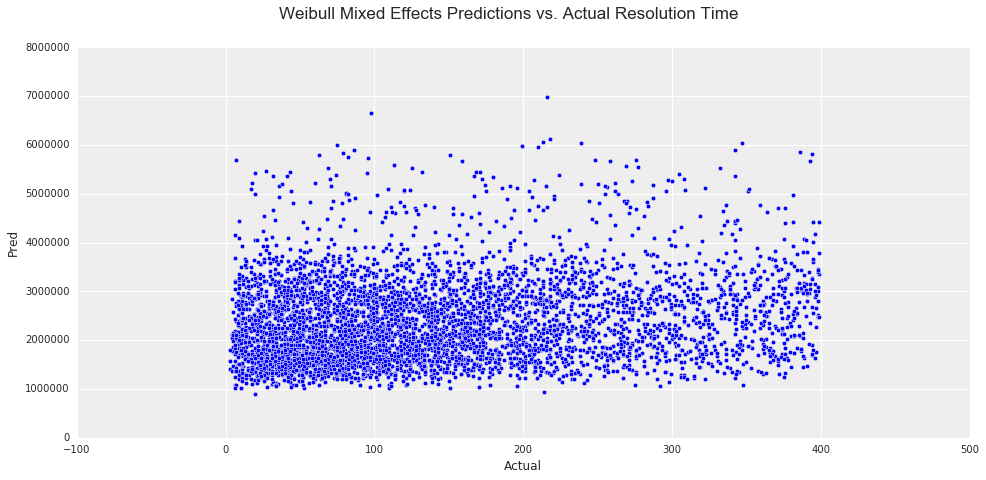

In [648]:
pd.DataFrame({"Pred":(ppc['y_est'].mean(axis=0) * 10000), "Actual": oos['responsetime'].values}).plot(x="Actual",
                                                                                              y="Pred",
                                                                                              kind="scatter",
                                                                                              figsize=(16, 7))
plt.suptitle("Weibull Mixed Effects Predictions vs. Actual Resolution Time", size=17)

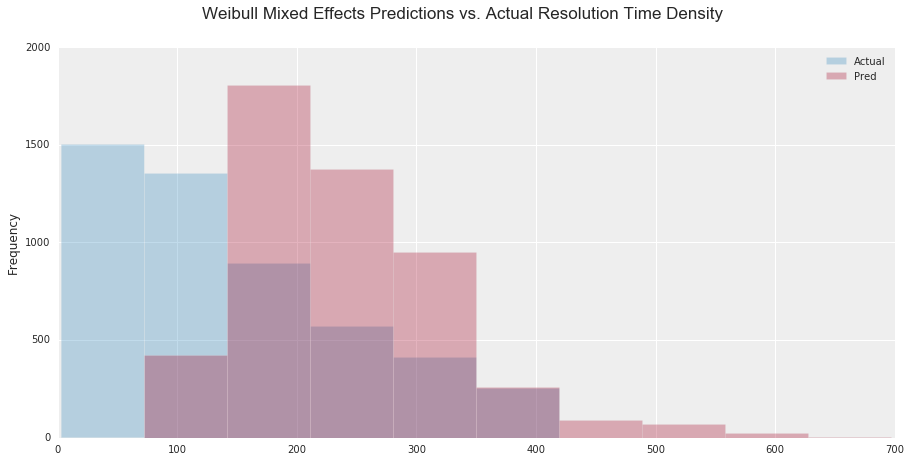

In [649]:
pd.DataFrame({"Pred":(ppc['y_est'].mean(axis=0)), "Actual": oos['responsetime'].values}).plot(kind="hist",
                                                                                              figsize=(15, 7),
                                                                                              alpha=.3)
plt.suptitle("Weibull Mixed Effects Predictions vs. Actual Resolution Time Density", size=17)

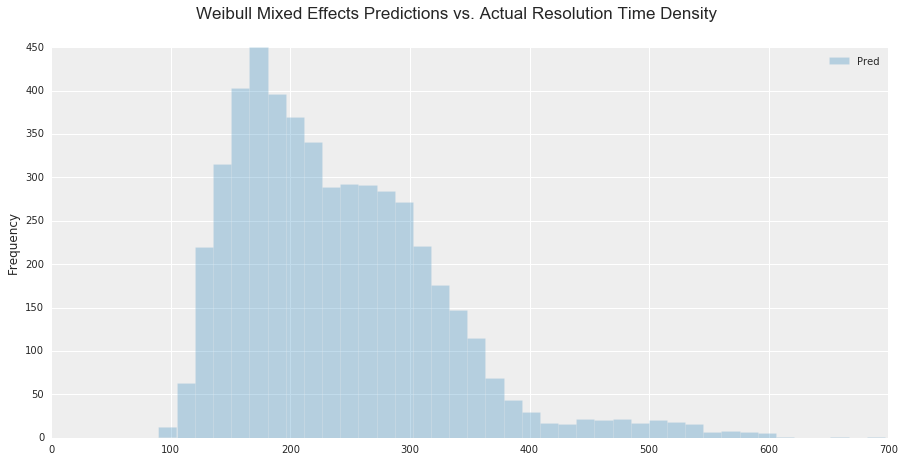

In [650]:
pd.DataFrame({"Pred":(ppc['y_est'].mean(axis=0))}).plot(kind="hist",figsize=(15,7), bins=40, alpha=.3)
plt.suptitle("Weibull Mixed Effects Predictions vs. Actual Resolution Time Density", size=17)

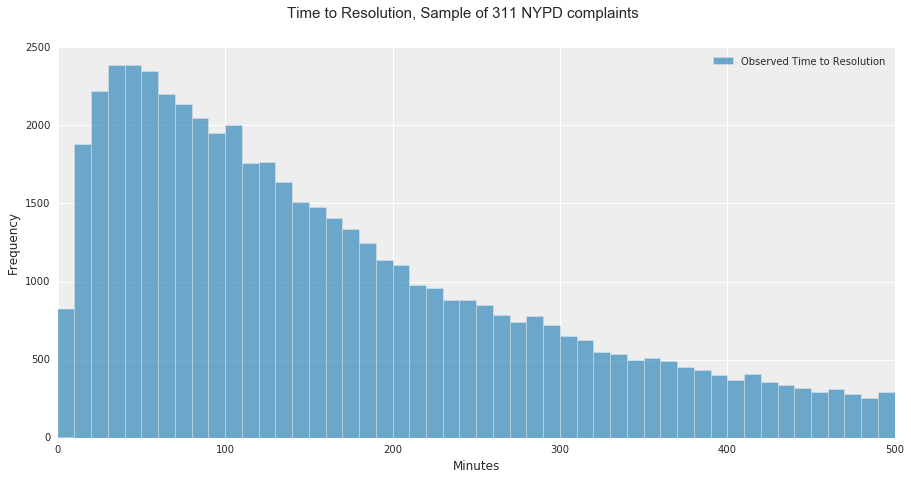

In [623]:
pd.DataFrame({"Observed Time to Resolution":y_obs}).plot(kind="hist",range=[0, 500], bins=50, figsize=(15,7), alpha=.7)
plt.suptitle("Time to Resolution, Sample of 311 NYPD complaints", size=15)
plt.xlabel("Minutes")

In [652]:
pm.summary(trace)


borough:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.518            0.260            0.026            [5.126, 5.882]
  5.337            0.122            0.012            [5.117, 5.598]
  4.671            0.116            0.011            [4.473, 4.906]
  4.984            0.193            0.019            [4.680, 5.294]
  4.242            0.209            0.021            [3.856, 4.688]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  5.116          5.313          5.437          5.768          5.875
  5.110          5.241          5.332          5.418          5.592
  4.475          4.573          4.676          4.744          4.908
  4.693          4.824          4.952          5.185          5.308
  3.852          4.117          4.239          4.373          4.684


precin

/Users/joshua/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
